In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import pi
from scipy import special as sp
import scipy.integrate as integrate
from scipy.interpolate import interp2d
from tqdm import tqdm
from scipy.constants import fine_structure, speed_of_light, electron_mass, elementary_charge, hbar, epsilon_0

In [2]:
#variáveis e constantes
electron_radius = elementary_charge**2/(4*pi*epsilon_0*electron_mass*speed_of_light**2)
num_pon = 200                                                      #número de pontos
mag_field = 5e2                                                 #[T] intensidade do campo magnético
tau_e = hbar/(speed_of_light**2*electron_mass)                     #[s] time it takes for light to travel across the electron radius electron_radius/speed_of_light
n_bins = 75                                                        #número de bins do histograma
t_end = 7.6e2                                                        #tempos finais
t_steps = 4000                                                     #numero de steps
t_int = t_end/t_steps
min_ene = 1
max_ene = 400
d_ene = min_ene/max_ene

time_lst = np.linspace(0, t_end, t_steps)
enelst = np.linspace(min_ene, max_ene, num_pon)

In [3]:
def getEnergy(x):
    return np.trapz(x*enelst, enelst)/np.trapz(x, enelst)

def cnst_prop_2(mag):
    return mag/(4.5*10**(9))

def bessel_integral(v):
    return integrate.quad(lambda x: sp.kv(5/3, x), v, np.Inf)[0]

#equacao 3.83 de 'Classical and Quantum Description of Plasma and Radiation in Strong Fields' de Fabien Niel
def G_tilde_int(chi, epsilon):
    v = 2 * epsilon / (3 * chi * (1 - epsilon))
    return np.sqrt(3) / (2 * pi) * epsilon * (
                integrate.quad(lambda x: sp.kv(5 / 3, x), v, np.inf)[
                    0] + 1.5 * epsilon * chi * v * sp.kv(2 / 3, v))

G_tilde_int_vec_aux = lambda chi1, epsilon1: G_tilde_int(chi1, epsilon1)

G_tilde_int_vec = np.vectorize(G_tilde_int_vec_aux)

epsilon_uni = np.linspace(0.0001, 0.9999, 40)

chi_uniform = np.linspace(5*10**(-8), 5*10**(-5), 40)

epsilon_uni_2d, chi_uniform_2d = np.meshgrid(epsilon_uni, chi_uniform)

G_tilde_int_vec_aux_2 = G_tilde_int_vec(chi_uniform_2d, epsilon_uni_2d)

G_tilde_inter = interp2d(chi_uniform_2d, epsilon_uni_2d, G_tilde_int_vec_aux_2, kind='cubic')

#equacao 3.82 de 'Classical and Quantum Description of Plasma and Radiation in Strong Fields' de Fabien Niel
def dN_dg(chi, epsilon):
    omega_c = elementary_charge * mag_field / (electron_mass * 1800)
    if chi/cnst_prop_2(mag_field) <= d_ene or epsilon * chi/cnst_prop_2(mag_field) <= d_ene or epsilon >= 1 or epsilon <= 0:
        return 0
    return (2 / 3) * fine_structure / tau_e / omega_c * G_tilde_inter(chi, epsilon) / (epsilon * (chi/cnst_prop_2(mag_field))**2)

/lib/python3.10/site-packages/scipy/interpolate/_fitpack_impl.py:977: RuntimeWarning: No more knots can be added because the additional knot would
coincide with an old one. Probable cause: s too small or too large
a weight to an inaccurate data point. (fp>s)
	kx,ky=3,3 nx,ny=46,8 m=1600 fp=0.000000 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))


In [4]:
dfdt_mat = np.zeros((num_pon, num_pon))
dfdt_mat_11_i = np.zeros_like(dfdt_mat)
dfdt_mat_11_o = np.zeros_like(dfdt_mat)

for i in range(num_pon):
    dfdt_mat_11_o[i, i] = -np.sum(np.array([dN_dg(enelst[i]*cnst_prop_2(mag_field), g/enelst[i]) for g in enelst[enelst<enelst[i]]]))

for i in range(num_pon):
    for j in range(i, num_pon):
        dfdt_mat_11_i[i, j] = dN_dg(enelst[j]*cnst_prop_2(mag_field), (enelst[j] - enelst[i])/enelst[j])

# add all submatrices
dfdt_mat = dfdt_mat_11_i+dfdt_mat_11_o

def dfdt(yn):
    return np.matmul(dfdt_mat,yn)

In [5]:
#RK4

#condicoes iniciais
yn = np.zeros(num_pon)
yn[np.abs(enelst-max_ene).argmin()] = 1

ene_lst_final = np.zeros(t_steps)

ffiga = np.zeros((t_steps, num_pon))
ffiga[0,:] = yn

ene_lst_final[0] = getEnergy(yn[:num_pon])/max_ene

for t in tqdm(range(1, t_steps)):
    k1 = dfdt(yn)
    k2 = dfdt(yn + t_int * k1 / 2)
    k3 = dfdt(yn + t_int * k2 / 2)
    k4 = dfdt(yn + t_int * k3)
    yn = yn + t_int / 6 * (k1 + 2 * k2 + 2 * k3 + k4)
    yn[yn <= 0] = 0

    ene_lst_final[t] = getEnergy(yn)/max_ene

    ffiga[t, :] = yn


<ipython-input-5-aeee286a928d>:14: TqdmMonitorWarning: tqdm:disabling monitor support (monitor_interval = 0) due to:
can't start new thread
  for t in tqdm(range(1, t_steps)):
100%|██████████| 3999/3999 [00:01<00:00, 3441.48it/s]


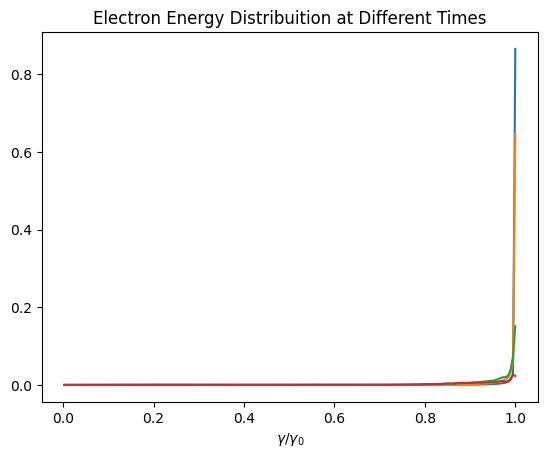

In [6]:
plt.title("Electron Energy Distribuition at Different Times")
plt.plot(enelst/max_ene, ffiga[int(t_steps*0.33/t_end)], label=r'0.33')
plt.plot(enelst/max_ene, ffiga[int(t_steps*0.66/t_end)], label=r'0.66')
plt.plot(enelst/max_ene, ffiga[int(t_steps*2.5/t_end)], label=r'2.5')
plt.plot(enelst/max_ene, ffiga[int(t_steps*4.999/t_end)], label=r'5')
plt.xlabel("${\gamma}/{\gamma_0}$")

plt.show()

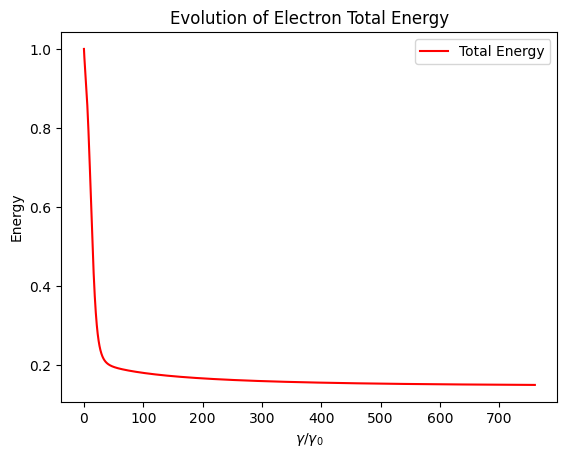

In [7]:
plt.title("Evolution of Electron Total Energy")
plt.plot(time_lst, ene_lst_final, label=r'Total Energy', color='red')
plt.ylabel("Energy")
plt.xlabel("${\gamma}/{\gamma_0}$")
plt.legend()

plt.show()